In [2]:
# import packages and libraries

#import osmnx as ox
import geopandas as gpd
from pathlib import Path
import folium 
import shapely


# init
@authors: [Alexandre Pereira Santos](alexandre.santos(at)lmu.de) & [Charlotta Mirbach](c.mirbach@lmu.de)

## data
- maximum flooded area 

## tasks
- generate a maximum flooded area that includes the maximum extent predicted among all generated observations
- fix geometrical errors (e.g., collinearity, self-intersection, etc)
- dissolve the polygons 
- export 


## functions

## preprocessing

### load input data

In [3]:
#input 06.05.2024 flooded area vector, as the "golden standard"
flood_path = Path('../data/external/')
flood_file = 'HYD_maximum_flood_extent_IPH_UFRGS_20240506_A.shp' 
flood_gdf = gpd.read_file(flood_path/flood_file)
#flood_gdf.drop(['gridcode','area'], axis=1, inplace=True)

# import the merged maximum surface
max_flood_path = Path('../data/raw/')
max_flood_file = 'ManchaRS.shp'
max_flood_gdf = gpd.read_file(max_flood_path/max_flood_file)


In [4]:
# check geometries from the maximum flood
from shapely.validation import explain_validity

max_flood_gdf['validity'] = max_flood_gdf.apply(lambda row: explain_validity(row.geometry), axis =1)
max_flood_gdf[max_flood_gdf['validity'] != 'Valid Geometry']

,altitudeMo,geometry,validity
21,12,"MULTIPOLYGON Z (((-51.10600 -29.96482 0.00000,...",Too few points in geometry component[-51.10794...
44,12,MULTIPOLYGON Z (((-51.38651 -30.09760 -1797693...,Ring Self-intersection[-51.2724934949999 -30.0...


In [5]:
max_flood_gdf.validity.unique()

array(['Valid Geometry',
       'Too few points in geometry component[-51.1079459010647 -29.9625733899988 0]',
       'Ring Self-intersection[-51.2724934949999 -30.034017314 -1.79769313486232e+308]'],
      dtype=object)

In [8]:
max_flood_gdf[max_flood_gdf['validity']=='Too few points in geometry component[-51.1079459010647 -29.9625733899988 0]'].explore()

In [9]:
max_flood_gdf[max_flood_gdf['validity']=='Ring Self-intersection[-51.2724934949999 -30.034017314 -1.79769313486232e+308]'].explore()

In [10]:
from shapely.validation import make_valid

max_flood_gdf.geometry = max_flood_gdf.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1)

C:\Users\ra42zek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\constructive.py:531: RuntimeWarning: overflow encountered in make_valid
  return lib.make_valid(geometry, **kwargs)


In [11]:
# checking if the corrections worked

max_flood_gdf['validity'] = max_flood_gdf.apply(lambda row: explain_validity(row.geometry), axis =1)
max_flood_gdf[max_flood_gdf['validity'] != 'Valid Geometry']

,altitudeMo,geometry,validity


In [15]:
# roi_gdf = gpd.GeoDataFrame(geometry=[mun[1].geometry],crs=mun_gdf.crs)
convex_gdf = gpd.GeoDataFrame(geometry=max_flood_gdf.envelope, crs=max_flood_gdf.crs)

<Axes: >

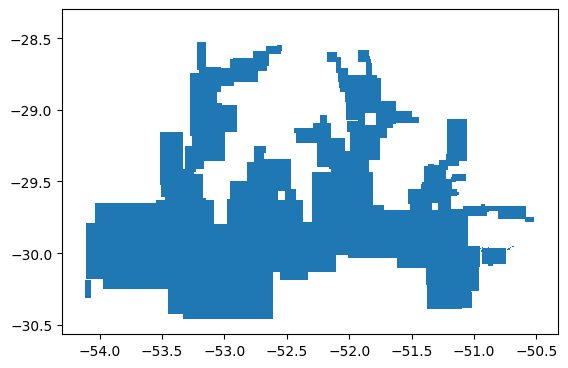

In [16]:
convex_gdf.plot()

In [8]:
buffer_gdf = max_flood_gdf.buffer(0)

<Axes: >

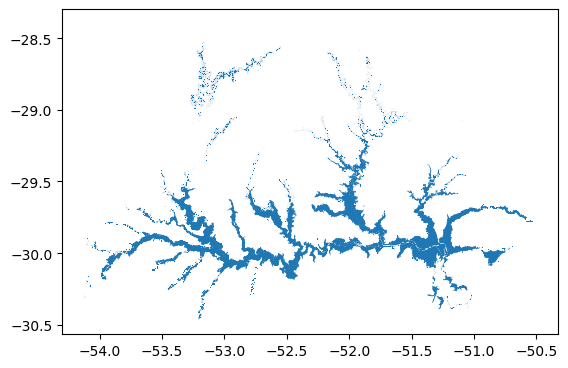

In [9]:
buffer_gdf.plot()

In [10]:
buffer_gdf.geometry.unique()

: 

In [7]:
# dissolve the geometries
from shapely import unary_union

dissolved_gdf = max_flood_gdf.unary_union()

C:\Users\ra42zek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:419: RuntimeWarning: overflow encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\ra42zek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shapely\set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


TypeError: 'MultiPolygon' object is not callable

<Axes: >

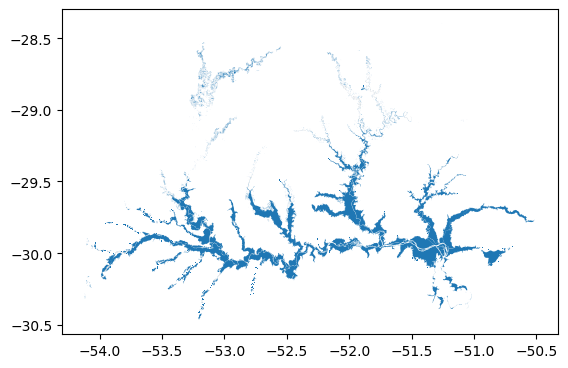

In [26]:
dissolved_gdf.plot()

In [27]:
dissolved_gdf

,geometry,altitudeMo,validity
0,MULTIPOLYGON Z (((-54.11627 -30.31478 -1797693...,12,Valid Geometry


: 

In [24]:
# export new shapefile
flood_path = Path('../data/processed')
flood_file = 'RS_HYD_maximum_flooded_area_2024_Planet_Sentinel_A.gpkg'
max_flood_gdf.to_file(flood_path / flood_file, driver='GPKG')